Here we revise an example of Hybrid QNN for classifying the MNIST dataset of handwritten digits, specifically 0 and 1, given in 
https://qiskit.org/documentation/machine-learning/tutorials/05_torch_connector.html.
As a quantum part of the model we employ an MPS circuit with qubit-effecient data loading introduced in 
http://arxiv.org/abs/1803.11537 [Fig. 11(a)] instead of a standart "dense" QNN circuit.

In [1]:
# Necessary imports

import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS

from qiskit import QuantumCircuit
from qiskit.utils import algorithm_globals
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

from qiskit.circuit.library import TwoLocal
from qiskit import Aer, transpile
from qiskit.circuit import QuantumCircuit, ParameterVector, Parameter
from qiskit.quantum_info import SparsePauliOp

# Set seed for random generators
algorithm_globals.random_seed = 42
backend = Aer.get_backend("aer_simulator")

In [2]:
# Additional torch-related imports
# import torch
from torch import cat, no_grad, manual_seed
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    NLLLoss,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
)
import torch.nn.functional as F

# Data

## Train Dataset

In [3]:
# Train Dataset
# -------------

# Set train shuffle seed (for reproducibility)
manual_seed(42)

batch_size = 1
n_samples = 100  # We will concentrate on the first 100 samples

# Use pre-defined torchvision function to load MNIST train data
X_train = datasets.MNIST(
    root="./data", train=True, download=True, transform=transforms.Compose([transforms.ToTensor()])
)

# Filter out labels (originally 0-9), leaving only labels 0 and 1
idx = np.append(
    np.where(X_train.targets == 0)[0][:n_samples], np.where(X_train.targets == 1)[0][:n_samples]
)
X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

# Define torch dataloader with filtered data
train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True)

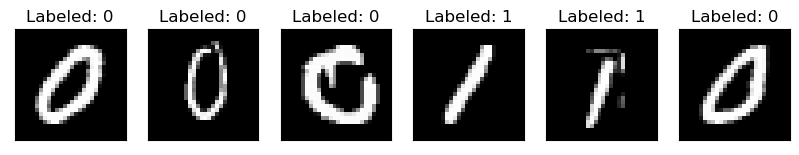

In [4]:
n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0, 0].numpy().squeeze(), cmap="gray")
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets[0].item()))

    n_samples_show -= 1

## Test Dataset

In [5]:
# Test Dataset
# -------------

# Set test shuffle seed (for reproducibility)
# manual_seed(5)

n_samples = 50

# Use pre-defined torchvision function to load MNIST test data
X_test = datasets.MNIST(
    root="./data", train=False, download=True, transform=transforms.Compose([transforms.ToTensor()])
)

# Filter out labels (originally 0-9), leaving only labels 0 and 1
idx = np.append(
    np.where(X_test.targets == 0)[0][:n_samples], np.where(X_test.targets == 1)[0][:n_samples]
)
X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

# Define torch dataloader with filtered data
test_loader = DataLoader(X_test, batch_size=batch_size, shuffle=True)

# Quantum MPS circuit with qubit-effecient data loading

In [6]:
# Number of classical bits outcoming out of a classical dense layer and loaded into the quantum circuit
N_logical_bits = 4
# Number of qbits in the circuit
N_qubits = 2
# Number of entangling layers in each quantum tensor
N_layers_in_tensor = 1
# Number of classical bits to load into each quantum tensor
N_load_per_tensor = 1

# Numbner of quantum tensors. N_qubits classical bits are first loaded into the initial qubits state and all other are loaded sequentially into quantum tensors.
N_tensors = (N_logical_bits - N_qubits)/N_load_per_tensor + 1
assert( N_tensors % 1 == 0 )
N_tensors = int(N_tensors)
N_tensors

3

In [7]:
# Sub-circuit of a single quantum tensor
q_tensor = TwoLocal(
    N_qubits,
    rotation_blocks=[ "rx","rz"],
    entanglement_blocks="cz",
    entanglement="linear",
    reps = N_layers_in_tensor,
    parameter_prefix = 'params',
    skip_final_rotation_layer = False,
    name = "Train"
)

In [9]:
# Full circuit
N_cbits = 1
circuit = QuantumCircuit(N_qubits, N_cbits)

# Parameters for decoding the input data
input_params = ParameterVector("input_params", N_logical_bits)
# Copy of parameters
input_params_0 = input_params
# Training parameters of indivisual QUANTUM tensor. Can be used to train tensors sequentially
q_tensor_params_sets = []
# All training parameters
train_params = []

# Insert first N_qubits classical bits into N_qubits qubits. A calssical bit is decoded as the rotation angle of a Rx gate
load_label = "$\mathrm{R}_\mathrm{X}$, Load"
for i in range(N_qubits):
    param, input_params = input_params[0], input_params[1:]
    circuit.rx(param * np.pi, i, label = load_label)
circuit.barrier()

# Insert the training tensor / reset a qubit / load next classical bit of information
for i in range( N_tensors ):
    
    params_set_i = ParameterVector("params_set_%i"%i, q_tensor.num_parameters)
    q_tensor_params_sets += [params_set_i]
    train_params += params_set_i
    
    # Insert the training tensor
    circuit.append(q_tensor.assign_parameters(params_set_i), range(N_qubits))
    circuit.barrier()
    
    if i!= N_tensors-1:
        for jj in range(N_load_per_tensor):
            # Reset a qubit
            circuit.reset(N_qubits-1 - jj)
            param, input_params = input_params[0], input_params[1:]
            
            # Load next classical bit of information
            circuit.rx( param * np.pi, N_qubits-1 - jj, label = load_label)
            
        circuit.barrier()

# Translate the circuit into the gates
circuit = transpile(circuit, backend)

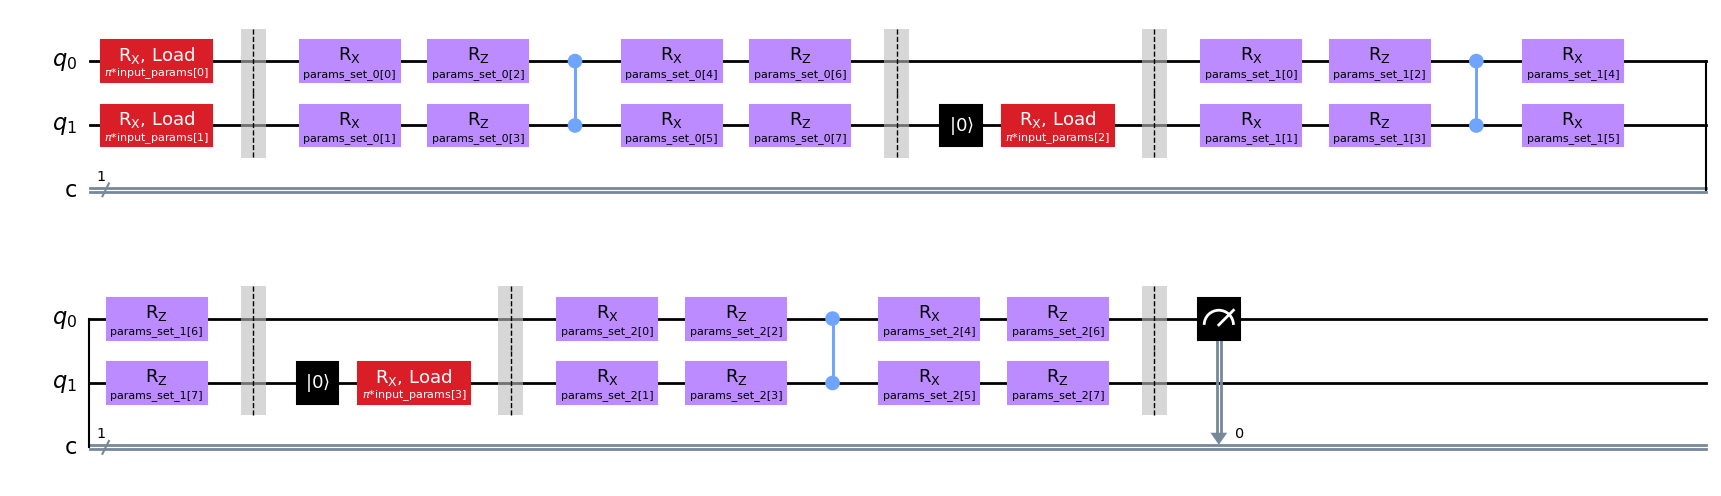

In [10]:
circuit_to_draw = circuit.copy()
circuit_to_draw.measure(0,0)
circuit_to_draw.draw("mpl",  style={'displaycolor': {load_label: ('#da1e28', '#FFFFFF')}})

In [11]:
# Estimator of the cost funtion. The observable is Z on the first qubit which provides probability of the sample to be 0 oe 1.
qnn = EstimatorQNN(
    circuit=circuit,
    observables = [SparsePauliOp.from_list([("Z" + "I"*(N_qubits-1), 1)])],
    input_params=input_params_0,
    weight_params=train_params,
    input_gradients=True,
)

# Hybride Model

In [12]:
# Define torch NN module: first we have classical layers which output N_logical_bits classical bits. The bits are loaded into the circuit which provides the output
class Net(Module):
    def __init__(self, qnn):
        super().__init__()
        self.conv1 = Conv2d(1, 2, kernel_size=5)
        self.conv2 = Conv2d(2, 16, kernel_size=5)
        self.dropout = Dropout2d()
        self.fc1 = Linear(256, 64)
        self.fc2 = Linear(64, N_logical_bits)  # N_logical_bits-dimensional input to QNN
        self.qnn = TorchConnector(qnn)  # Apply torch connector, weights chosen
        # uniformly at random from interval [-1,1].
        self.fc3 = Linear(1, 1)  # 1-dimensional output from QNN

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.qnn(x)  # apply QNN
        x = self.fc3(x)
        return cat((x, 1 - x), -1)


model = Net(qnn)

# Train Model 

In [13]:
# Define model, optimizer, and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = NLLLoss()

# Start training
epochs = 10  # Set number of epochs
loss_list = []  # Store loss history
model.train()  # Set model to training mode

for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad(set_to_none=True)  # Initialize gradient
        output = model(data)  # Forward pass
        loss = loss_func(output, target)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize weights
        total_loss.append(loss.item())  # Store loss
        
    loss_list.append(sum(total_loss) / len(total_loss))
    print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]))

Training [10%]	Loss: -1.0370
Training [20%]	Loss: -1.3949
Training [30%]	Loss: -1.6134
Training [40%]	Loss: -1.8370
Training [50%]	Loss: -2.0778
Training [60%]	Loss: -2.3161
Training [70%]	Loss: -2.5295
Training [80%]	Loss: -2.7482
Training [90%]	Loss: -2.9527
Training [100%]	Loss: -3.1707


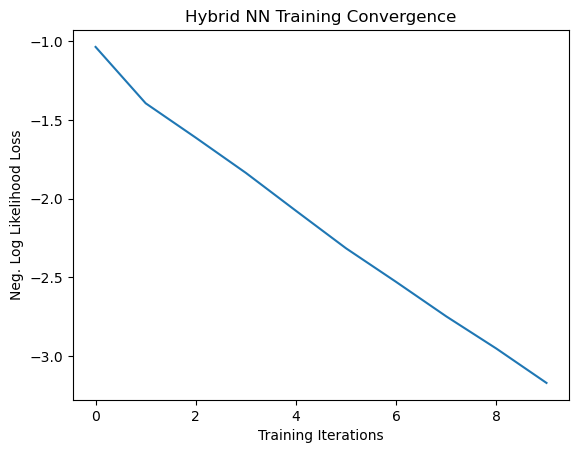

In [14]:
# Plot loss convergence
plt.plot(loss_list)
plt.title("Hybrid NN Training Convergence")
plt.xlabel("Training Iterations")
plt.ylabel("Neg. Log Likelihood Loss")
plt.show()

In [15]:
model.eval()  # set model to evaluation mode
with no_grad():

    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = loss_func(output, target)
        total_loss.append(loss.item())

    print(
        "Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%".format(
            sum(total_loss) / len(total_loss), correct / len(test_loader) / batch_size * 100
        )
    )

Performance on test data:
	Loss: -3.2128
	Accuracy: 100.0%



VS 

Loss: -1.7831<br>
Accuracy: 98.0%

in the Qiskit example using the same number of qubits<br>
https://qiskit.org/documentation/machine-learning/tutorials/05_torch_connector.html

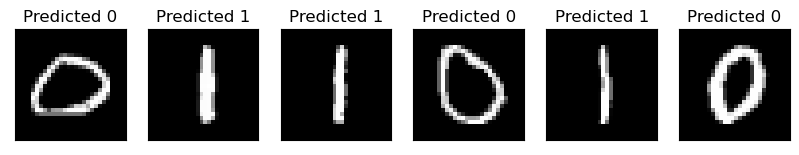

In [16]:
# Plot predicted labels

n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model.eval()
with no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model(data[0:1])
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)

        axes[count].imshow(data[0].numpy().squeeze(), cmap="gray")

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title("Predicted {}".format(pred.item()))

        count += 1